In [4]:
import random
from random import shuffle

from PIL import Image, ImageFilter
from IPython import display

from matplotlib.pyplot import imshow
%matplotlib inline

import pickle
import time

from sampling_utils import *
from gen_utils import *
from config_db import ConfigDB

In [5]:
num_pics = 100
min_num_cars = 1
max_num_cars = 3

domains = [[52,76],[1,25],[0,1],[0.35,1],[0.5,1.5],[0.25,1],[0.5,1],[0.5,1]]
types = ['int','int','float','float','float','float','float','float']

gen_misclass = False
store_config_db = False
store_err_tab = False

IOMIN_THRESH = 0.5
IOU_THRESH = 0.5

if gen_misclass:
    checkpoint = '/home/xyyue/checkpoint/final/model.ckpt-5000'
    import squeezedet as nn
    net = nn.init(checkpoint)

In [ ]:
# Init data structure
if store_err_tab:
    err_table = error_table()
if store_config_db:
    config_db = ConfigDB()
    
total_attempts = 0
rejections = 0

for j in range(min_num_cars,max_num_cars):
    
    path_data_set = './data/test/'    
    
    i = 0
    v = 0

    while i < num_pics:

        # Sample configuration
        num_cars = random.randint(min_num_cars, max_num_cars)
        sample_dims = [1,num_cars,num_cars,num_cars,1,1,1,1]
        sample, norm_sample = get_sample(v, 'random', types=types, domains=domains, dims=sample_dims)
        sample[3].sort(reverse=True)
        norm_sample[3].sort(reverse=True)
        
        total_attempts += 1
        
        good_sample = True
        # Check sample distance from stored ones
        if store_config_db:
            sample_pad = pad_sample(sample)
            good_sample = config_db.eps_dist(sample_pad,0.5)
            
            
        if good_sample:
            # Generate image from sample
            img, ground_boxes, img_info = gen_image(sample)

            # Is it a good picture? (cars don't overlap too much)
            save_img = True
            for m in range(len(ground_boxes)):
                for n in range(m+1, len(ground_boxes)):
                    #print(iomin(ground_boxes[m], ground_boxes[n]))
                    if iomin(ground_boxes[m], ground_boxes[n]) > IOMIN_THRESH:
                        save_img = False

            # Check misclassification
            if gen_misclass and save_img:
                # Save tmp image    
                tmp_img_file_name = './tmp.png'
                img.save(tmp_img_file_name)

                # Classify img
                (boxes,probs,cats) = nn.classify(tmp_img_file_name,net) 

                save_img = False

                # Not cars
                if any(cats):
                    save_img = True
                else:
                    all_good_boxes = True
                    for ground_box in ground_boxes:
                        found_good_box = False
                        for box, prob in zip(boxes, probs):    
                            found_good_box = found_good_box or ((iou(ground_box, box) > IOU_THRESH) and prob > 0.5)
                        all_good_boxes = all_good_boxes and found_good_box
                    save_img = not(all_good_boxes)

            if save_img:
                
                if store_config_db:
                    config_db.add(sample_pad)            
                
                file_name = 'm_' + str(j) + '_' + str(i).zfill(6)

                # Save data
                save_image(img, file_name, path_data_set)
                save_label(ground_boxes, file_name, path_data_set)
                
                if store_err_tab:
                    err_table.update_with_elem(img_info)
                    
                i+=1
        else:
            rejections += 1

        if(total_attempts %50 == 0):
            print('gen pics: ' + str(total_attempts) + ' | misclass pics: ' + str(i) + ' | rejections: ' +str(rejections))
            

if store_err_tab:
    err_table_file = open(path_data_set + 'error_table' + str(),'w')
    pickle.dump(err_table,err_table_file)
    err_table_file.close()

gen pics: 50 | misclass pics: 25 | rejections: 0
gen pics: 100 | misclass pics: 43 | rejections: 0
gen pics: 150 | misclass pics: 61 | rejections: 0
gen pics: 200 | misclass pics: 81 | rejections: 0
gen pics: 250 | misclass pics: 99 | rejections: 0


In [12]:
random.randint(1, 2)

2

In [4]:
gen_image??

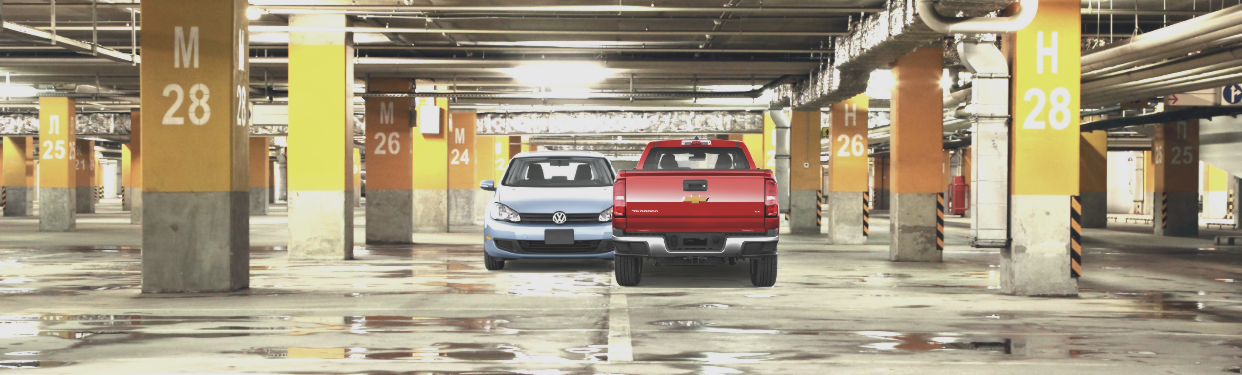

In [11]:
img, ground_boxes, img_info = gen_image([[76], [19, 19, 25], [0.9336892224152523, 0.1655256197149313, 0.9166387326580357], [0.7786505130347865, 0.45977209336021896, 0.4422130902551024], [1.4375360130681998], [0.7688548110832314], [0.6458348164511062], [0.7299862889017714]])
display.display(img)

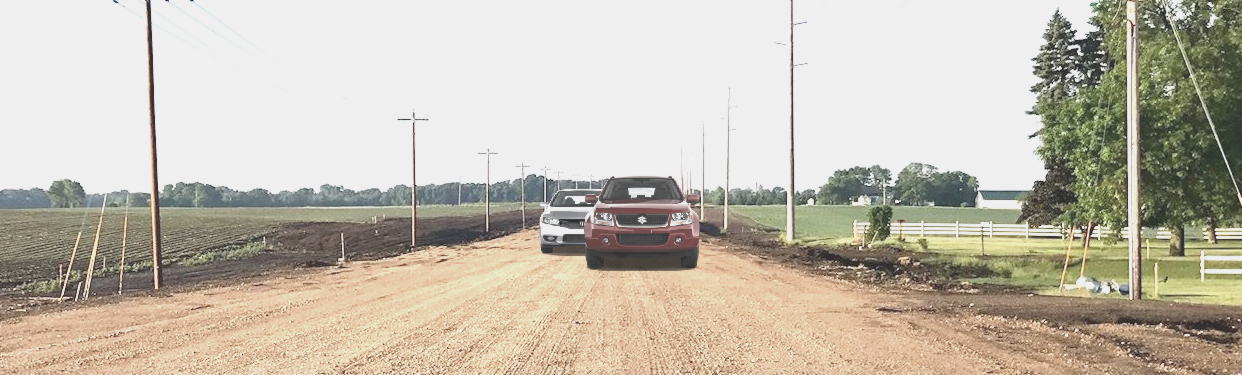